# RISE: Randomized Input Sampling for Explanation of Black-box Models
#### Vitali Petsiuk, Abir Das, Kate Saenko (BMVC'2018)
https://arxiv.org/abs/1806.07421 <br>
https://github.com/eclique/RISE

If you are working from colab, go to Edit > Notebook settings > Hardware accelerator and set it to GPU for better perfromance.

In [1]:
out = !wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip
out = !wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip
out = !wget https://www.dropbox.com/s/n4ooh6knkstdqlr/RISE_aux.zip
out = !unzip vocap.zip
out = !unzip pretrained_model.zip
out = !unzip RISE_aux.zip
out = !rm vocap.zip pretrained_model.zip RISE_aux.zip

RISE is a method for salincy attribution. Unlike the gradient-based methods that you have experimented with in the previous task, RISE is based on *perturbation*.
Perturbation methods manipulate the input and observe how changes in different input regions affect the output of the model. And based on these observations a saliency map is produced.
Types of perturbations include blacking out pixels, blurring them, adding noise, *etc*.

<img src="https://camo.githubusercontent.com/b27fb96007a21a6aefe8c3840c47490dff2e62b2/68747470733a2f2f65636c697175652e6769746875622e696f2f7265702d696d67732f524953452f726973652d6f766572766965772e706e67" style="width: 700px;"/>

RISE queries the model with many masked versions of the input and uses class probabilities computed by the model as weights for the corresponding masks. If one of the masks has removed something important for category prediction from the image, the model will produce low probability for this category, hence the mask will get a small weight in the some. Therefore, the resulting saliency map will highlight regions that the model deems important.

Formally,
$$
    S_{I, f} = \frac1{\sum_{i=1}^N M_i}\sum_{i=1}^N f(I\odot M_i)\cdot M_i,
$$
where $S_{I,f}$ is a saliency map for image $I$ and black-box model $f$, and $\{M_i\}$ is a set of $N$ masks. $f$ estimates the class probabilities $P(c_j)$.

RISE doesn't depend on any of the model's internals, such as weights, gradients or activations. It treats the model as a black box and relies only on observing it's output probabilities. Being a black-box method, it can be easily applied to different model architectures and sometimes new tasks. In this part of the class we will see, how it can be extended to produce saliency maps for image captioning models. The disadvantage of such techniques is their long runtime.

In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import os
import pickle
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
from tqdm import tqdm

import torch.nn as nn
from torchvision import transforms, models



### Some utility functions

In [4]:
# Function that opens image from disk, normalizes it and converts to tensor
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0),
    lambda x: x.to(device)
])

def get_class_name(c):
    """Given label id returns imagenet class name"""
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    return ' '.join(labels[c].split(',')[0].split()[1:])

def tensor_imshow(inp, sal=None, title=None):
    """Denormalizes image and displays it."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis('off')
    plt.imshow(inp)
    if sal is not None:
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar()
    if title is not None:
        plt.title(title)
        
def generate_masks(N, s, p1, input_size = (224, 224)):
    cell_size = np.ceil(np.array(input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                     anti_aliasing=False)[x:x + input_size[0], y:y + input_size[1]]
    masks = masks.reshape(-1, 1, *input_size)
    np.save(masks_filepath, masks)
    masks = torch.from_numpy(masks)
    masks = masks.float().to(device)
    return masks

## Classification

Let's first see how the method works for image classification. We generate $N$ masks, that we apply to zero out parts of the image by multiplying image tensor with the masks. The masks are upsampled from small resolution $s\times s$ binary grids where every cell has a probability $p_1$ of being set to $1$ and $1-p_1$ of being set to $0$. The masks are then upsampled to image resolution using bilinear interpolation.

#### Load the classification model

In [5]:
model = models.resnet50(pretrained=True) # Can be any classification model
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


#### Generate RISE masks

In [6]:
masks_filepath = 'masks.npy'
N = 5000
s = 15
p1 = 0.5
force_recompute = False

if force_recompute or not os.path.isfile(masks_filepath):
    masks = generate_masks(N, s, p1, input_size=(224, 224))
else:
    masks = np.load(masks_filepath)
    masks = torch.from_numpy(masks)
    masks = masks.float().to(device)    
mask_sum = masks.sum(0)[0].cpu().numpy() # For normalization

Generating masks: 100%|██████████| 5000/5000 [00:19<00:00, 260.38it/s]


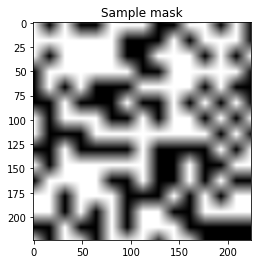

In [7]:
plt.title('Sample mask')
plt.imshow(masks[0, 0].cpu(), cmap='gray')
plt.show()

In [9]:
!wget https://github.com/NY1024/Experimental_Material/raw/master/dog_cat.png

--2021-07-08 00:02:04--  https://github.com/NY1024/Experimental_Material/raw/master/dog_cat.png
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NY1024/Experimental_Material/master/dog_cat.png [following]
--2021-07-08 00:02:04--  https://raw.githubusercontent.com/NY1024/Experimental_Material/master/dog_cat.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112604 (110K) [image/png]
Saving to: ‘dog_cat.png’

dog_cat.png         100%[===================>] 109.96K  --.-KB/s    in 0.01s   

2021-07-08 00:02:04 (7.63 MB/s) - ‘dog_cat.png’ saved [112604/112604]



#### Saliency maps for classification

In [10]:
# Load an image
img_t = read_tensor('dog_cat.png')
_, _, H, W = img_t.size() # Image dimentions
stack = None
# Apply array of masks to the image
stack = torch.mul(masks, img_t)

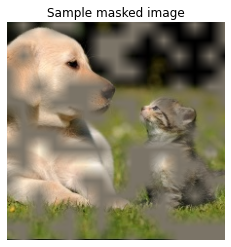

In [11]:
tensor_imshow(stack[0].cpu(), title='Sample masked image')
plt.show()

Run the model on masked images, compute the probabilities and generate saliency maps for all caetgories in one pass.

In [12]:
# Equivalent to p = model(stack) processed in batches
gpu_batch = 250
p = []
with torch.no_grad():
    for i in tqdm(range(0, N, gpu_batch), desc='Running model on masked images'):
        p.append(model(stack[i:min(i + gpu_batch, N)]))
p = torch.cat(p)

Running model on masked images:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Running model on masked images: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


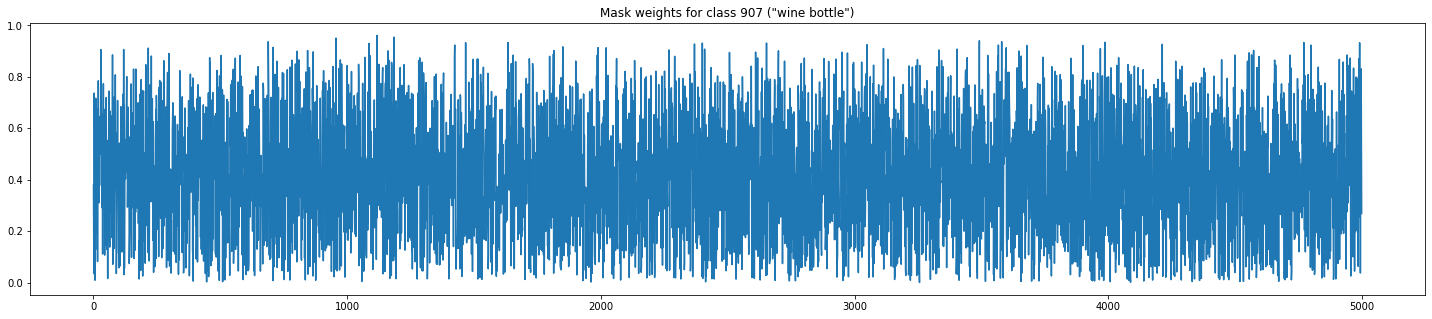

In [ ]:
plt.figure(figsize=(25, 5))
plt.title('Mask weights for class 907 ("wine bottle")')
plt.plot(p[:, 907].cpu())
plt.show()

In [13]:
# Compute weighted sum, reshape and normalize
CL = p.size(1) # Number of classes
sal = torch.matmul(p.transpose(0, 1), masks.view(N, H * W))
sal = sal.view((CL, H, W))
sal = sal.cpu().numpy() / mask_sum

In [14]:
def show_results(img, sal, top_k=3):
    p, c = torch.topk(model(img.cuda()), k=top_k)
    p, c = p[0], c[0]
    
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {}'.format(100*p[k], get_class_name(c[k])))
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(get_class_name(c[k]))
        tensor_imshow(img[0], sal[c[k]])
    plt.show()

In [16]:
!wget https://github.com/HoldenCaulfieldRye/caffe/blame/master/data/ilsvrc12/synset_words.txt

--2021-07-08 00:03:55--  https://github.com/HoldenCaulfieldRye/caffe/blame/master/data/ilsvrc12/synset_words.txt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘synset_words.txt’

synset_words.txt        [ <=>                ] 402.19K  --.-KB/s    in 0.04s   

2021-07-08 00:03:56 (10.8 MB/s) - ‘synset_words.txt’ saved [411843]



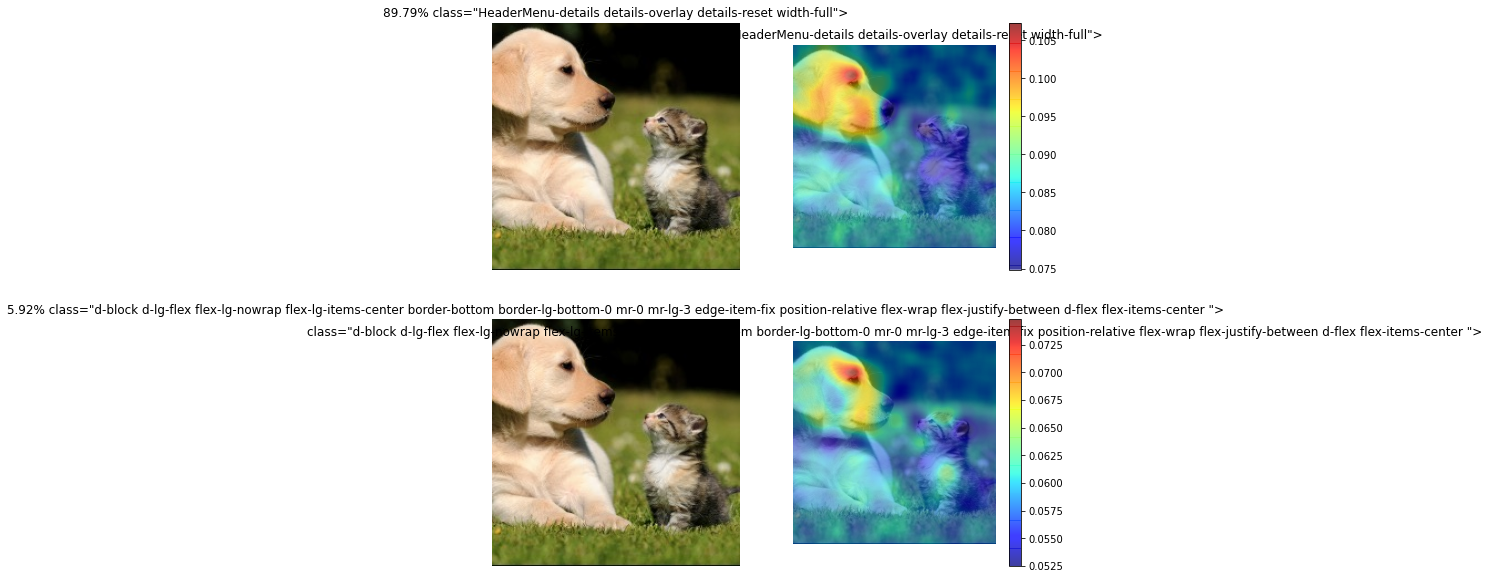

In [18]:
show_results(img_t.cpu(), sal, top_k=2)

<img src="https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png" style="width: 700px;"/>

Answer:

#### Result

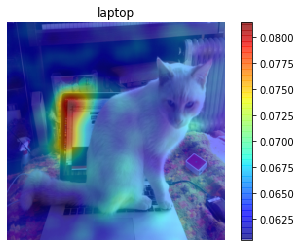

In [ ]:
tensor_imshow(image_tensor[0].data.cpu(), sal, title=explain_word)
plt.show()

#### More examples:

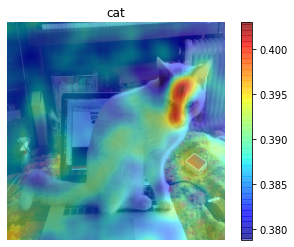

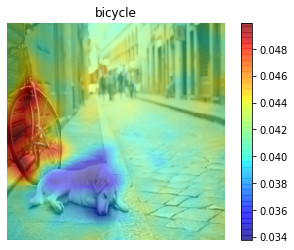

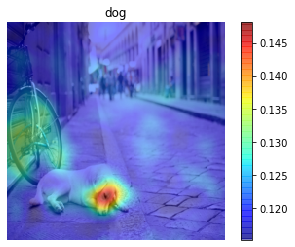

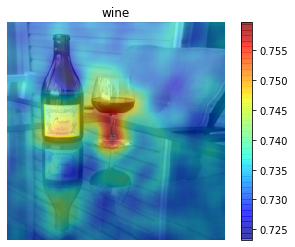

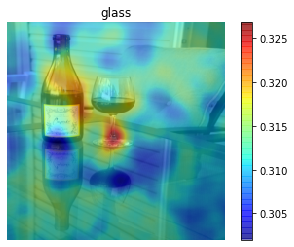